In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('../datasets/final_dataset.csv') # read the csv file

In [3]:
version = "cnn_v2"

In [4]:
df.head()

,Disease,Symptoms
0,Yeast Infection,I'm experiencing itching and burning sensation...
1,Yeast Infection,I'm feeling intense itching and irritation aro...
2,Yeast Infection,"I have a yeast infection, and I'm experiencing..."
3,Yeast Infection,I've noticed itching and burning in my vaginal...
4,Yeast Infection,I'm experiencing itching and discomfort in my ...


In [5]:
###Drop Nan Values
df=df.dropna()

In [6]:
df.columns

Index(['Disease', 'Symptoms'], dtype='object')

In [7]:
import tensorflow as tf

In [8]:
tf.__version__

'2.16.1'

In [9]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D

In [10]:
### Vocabulary size
voc_size=50000

In [11]:
df.columns

Index(['Disease', 'Symptoms'], dtype='object')

In [12]:
df.reset_index(inplace=True)

In [13]:
### Dataset Preprocessing
from word_process import WordProcess

wp = WordProcess()

corpus = []

for i in range(0, len(df)):
    review = wp.process_sent2sent(df['Symptoms'][i])
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aller\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aller\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aller\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
corpus[:5]

['experience itch burn sensation vaginal area along unusual discharge thick white cottage cheese like consistency',
 'feel intense itch irritation around genital area noticeable white clumpy discharge',
 'yeast infection experience severe itch redness vaginal area discharge thick white',
 'notice itch burn vaginal area along thick white discharge strong odor',
 'experience itch discomfort vaginal area along thick white discharge itch bad intercourse use scent product']

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer


# Initialize Tokenizer
tokenizer = Tokenizer(lower=True, split=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)

# Convert texts to sequences of integers
onehot_repr = tokenizer.texts_to_sequences(corpus)

In [16]:
import pickle
with open(f'../models/tokenizer_{version}.pkl', 'wb') as f:  # Open the file in write-binary mode
    pickle.dump(tokenizer, f)    

In [17]:
# making all the sentences of the same length
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

print(embedded_docs)

[[  0   0   0 ... 438  37 974]
 [  0   0   0 ...  99 975  98]
 [  0   0   0 ...  98  59  99]
 ...
 [  0   0   0 ... 797  32 140]
 [  0   0   0 ...  78 184  78]
 [  0   0   0 ... 230  10 384]]


In [18]:
embedded_docs[0]

array([  0,   0,   0,   0,   0,   6,  18, 170, 137, 138,  52,  22, 507,
        98,  59,  99, 437, 438,  37, 974])

In [19]:
df['Disease'].nunique()     

30

In [20]:
embedding_vector_features=40

In [21]:
num_classes = 30
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_shape=(sent_length,)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

C:\Users\aller\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 40)              │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 18, 64)              │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,076,774 (7.92 MB)

 Trainable params: 2,076,774 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
df['Disease'] =  df['Disease'].apply(lambda x: x.lower())
diseases = pd.get_dummies(df['Disease']).columns

In [23]:
diseases.get_loc('common cold'), df[df['Disease'] == 'common cold'].iloc[0]['Symptoms']

(6,
 "I can't stop sneezing and my nose is really runny. I'm also really cold and tired all the time, and I've been coughing a lot. My fever is really high too, like way above normal.")

In [24]:
y = df['Disease'].apply(lambda x: diseases.get_loc(x))

In [25]:
# saving titles of diseases to a text file for future use

import json
with open(f'../models/disease_classes_{version}.txt', 'w') as f:
    f.write(json.dumps( pd.get_dummies(df['Disease']).columns.values.tolist()))

In [26]:
len(embedded_docs),y.shape

(1504, (1504,))

In [27]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [28]:
# X_final = np.expand_dims(X_final, axis=-1)
X_final.shape,y_final.shape

((1504, 20), (1504,))

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [30]:
# early_stopping means that the model will stop training if the validation loss does not decrease for 3 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Wait for 5 epochs without improvement 
    mode='min',          # Minimize validation loss
    restore_best_weights=True  # Restore weights from the best epoch
)

In [31]:
##Training
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64,callbacks=[early_stopping])

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0400 - loss: 3.3993 - val_accuracy: 0.0543 - val_loss: 3.3893
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0759 - loss: 3.3689 - val_accuracy: 0.0926 - val_loss: 3.3266
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1291 - loss: 3.2265 - val_accuracy: 0.1006 - val_loss: 3.0547
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1664 - loss: 2.8452 - val_accuracy: 0.2314 - val_loss: 2.7563
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3427 - loss: 2.3910 - val_accuracy: 0.3581 - val_loss: 2.2595
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5025 - loss: 1.8366 - val_accuracy: 0.5091 - val_loss: 1.7526
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6489 - loss: 1.2987 - val_accuracy: 0.6499 - val_loss: 1.3074
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7992 - loss: 0.8610 - val_accuracy: 0.7042 - v

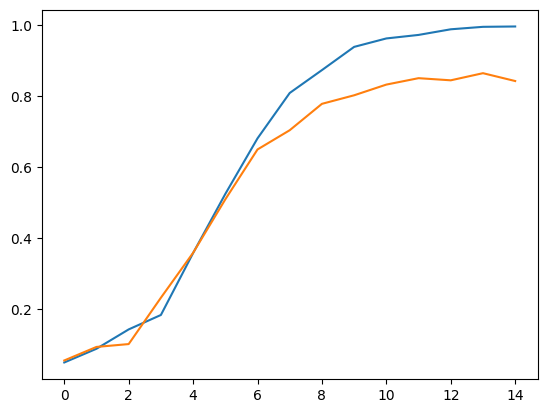

In [32]:
import matplotlib.pyplot as plt
# plot line graph of history of accuracy and val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [33]:
y_pred=model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [34]:
# y_pred[0].argmax()
# y_test[0].argmax()

# y_test_t = [i.argmax() for i in y_test]
y_pred_t = [i.argmax() for i in y_pred]

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_t)

0.8651911468812877

In [36]:
# save model weights
model.save_weights(f'../models/model_{version}.weights.h5')